## Tasks
Assigned to Sierra Stevenson, JSIP intern under Dr. Jonathan Jiang and Dr. Longtao Wu<p>
This analysis is intended to compare observed (MLS/AIRS/GPM_MERGIR) and simulated (UM) data to evaluate<br>how convection is resolved by storm-resolving models.

List of Tasks<p>
[DONE]&nbsp;&nbsp;&nbsp;Task 1 — UM moisture at 100 hPa map<br>
[DONE]&nbsp;&nbsp;&nbsp;Task 2 — MLS moisture at 100 hPa map<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 3 — UM/MLS/AIRS vert. profiles pressure vs temp/moisture<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 4 — UM/MLS PDFs (moisture)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 5 — UM/GPM_MERGIR PDFs (brightness temp)

UM (monthly): Task 1,2
MLS (monthly): Task 1,2

UM (hourly): Task 3-5
MLS (hourly): Task 3-5
AIRS (hourly): 

## Code
Setup

In [19]:
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.stats as sst
import dask
import os
import glob
import below_god as bg
import seaborn as sns
import parmap
import tqdm

from metpy.interpolate import log_interpolate_1d
from metpy.units import units
from netCDF4 import MFDataset, Dataset, num2date
from pydap.client import open_url

In [20]:
# Conversion factors
hPa_to_Pa = 100
kgkg_to_ppmv = 1.608 * 10 ** 6
VMR_to_ppmv = 10 ** 6
K_to_C = 273.15

# Monsoon region coordinates (format: [lon1,lon2,lat1,lat2])
# Asian Monsoon
AM_coords = [20, 160,-10,50]
AM_box = [[20,40],[40,140]]

# North American Monsoon
NAM_coords = [-140,-40,-10,50]
NAM_box = [[-10,40],[-140,60]]

# Function to select region
def RegionSelect(xarr, region):
    if region == "AM":
        return xarr.sel(latitude=slice(AM_coords[2],AM_coords[3])).sel(longitude=slice(AM_coords[0],AM_coords[1]))
    elif region == "NAM":
        return xarr.sel(latitude=slice(NAM_coords[2],NAM_coords[3])).sel(longitude=slice(NAM_coords[0],AM_coords[1]))
    else:
        print("Region must be either AM or NAM.")

### AIRS data

In [21]:
# Starting with yearly
# TODO: When code is confirmed to work, set to daily and re-run after JPL work hours.

In [22]:
AIRS_file_names = []
AIRS_file1 = '/data/airs/AIRX3STD/v7/2003/AIRS.2003.08.15.L3.RetStd001.v7.0.3.0.G20202222706.hdf'
AIRS_data_yrly = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(AIRS_file1)))

yearly_AIRS = '/data/airs/AIRX3STD/v7/*/AIRS.*.08.15.L3.RetStd001.v7.0.3.0.*.hdf'
# daily_AIRS = '/data/airs/AIRX3STD/v7/*/AIRS.*.08.*.L3.RetStd001.v7.0.3.0.*.hdf'     # TODO: Include up to 09/08

print("Beginning loop. Runtime: 9 sec per file. (2-4 min for yearly data; 70 min for daily data.")

for file in glob.glob(yearly_AIRS):
    print(file)
    AIRS_file_names.append(file)
    AIRS_data_yrly = xr.concat([AIRS_data_yrly, xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(file)))], dim="time")

Beginning loop. Runtime: 9 sec per file. (2-4 min for yearly data; 70 min for daily data.
/data/airs/AIRX3STD/v7/2003/AIRS.2003.08.15.L3.RetStd001.v7.0.3.0.G20202222706.hdf
/data/airs/AIRX3STD/v7/2004/AIRS.2004.08.15.L3.RetStd001.v7.0.3.0.G20195222930.hdf
/data/airs/AIRX3STD/v7/2005/AIRS.2005.08.15.L3.RetStd001.v7.0.3.0.G20194175526.hdf
/data/airs/AIRX3STD/v7/2006/AIRS.2006.08.15.L3.RetStd001.v7.0.3.0.G20193130345.hdf
/data/airs/AIRX3STD/v7/2007/AIRS.2007.08.15.L3.RetStd001.v7.0.3.0.G20192120413.hdf
/data/airs/AIRX3STD/v7/2008/AIRS.2008.08.15.L3.RetStd001.v7.0.3.0.G20191235723.hdf
/data/airs/AIRX3STD/v7/2009/AIRS.2009.08.15.L3.RetStd001.v7.0.3.0.G20191120349.hdf
/data/airs/AIRX3STD/v7/2010/AIRS.2010.08.15.L3.RetStd001.v7.0.3.0.G20185230916.hdf
/data/airs/AIRX3STD/v7/2011/AIRS.2011.08.15.L3.RetStd001.v7.0.3.0.G20184153420.hdf
/data/airs/AIRX3STD/v7/2012/AIRS.2012.08.15.L3.RetStd001.v7.0.3.0.G20183101552.hdf
/data/airs/AIRX3STD/v7/2013/AIRS.2013.08.15.L3.RetStd001.v7.0.3.0.G20181235357.h

In [23]:
AIRS_data_yrly = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(AIRS_file1)))
AIRS_data_yrly

<xarray.Dataset>
Dimensions:                              (YDim:ascending: 180,
                                          XDim:ascending: 360,
                                          EmisFreqIR:ascending: 4,
                                          StdPressureLev:ascending: 24,
                                          H2OPressureLay:ascending: 12,
                                          H2OPressureLev:ascending: 12,
                                          ...
                                          StdPressureLev:ascending_MW_only: 24,
                                          YDim:descending_MW_only: 180,
                                          XDim:descending_MW_only: 360,
                                          EmisFreqMW:descending_MW_only: 3,
                                          StdPressureLev:descending_MW_only: 24,
                                          YDim:location: 180, XDim:location: 360)
Coordinates: (12/40)
  * XDim:ascending                       (XDim:ascending) float64 -180.0 ... ...
  * YDim:ascending                       (YDim:ascending) float64 90.0 ... -89.0
  * StdPressureLev:ascending             (StdPressureLev:ascending) float32 1...
  * EmisFreqIR:ascending                 (EmisFreqIR:ascending) float32 832.0...
  * CoarseCloudLayer:ascending           (CoarseCloudLayer:ascending) float32 ...
  * FineCloudLayer:ascending             (FineCloudLayer:ascending) float32 1...
    ...                                   ...
  * StdPressureLev:ascending_MW_only     (StdPressureLev:ascending_MW_only) float32 ...
  * EmisFreqMW:ascending_MW_only         (EmisFreqMW:ascending_MW_only) float32 ...
  * XDim:descending_MW_only              (XDim:descending_MW_only) float64 -1...
  * YDim:descending_MW_only              (YDim:descending_MW_only) float64 90...
  * StdPressureLev:descending_MW_only    (StdPressureLev:descending_MW_only) float32 ...
  * EmisFreqMW:descending_MW_only        (EmisFreqMW:descending_MW_only) float32 ...
Dimensions without coordinates: YDim:location, XDim:location
Data variables: (12/400)
    TotalCounts_A                        (YDim:ascending, XDim:ascending) float32 ...
    SurfPres_Forecast_A                  (YDim:ascending, XDim:ascending) float32 ...
    SurfPres_Forecast_A_ct               (YDim:ascending, XDim:ascending) float32 ...
    SurfPres_Forecast_A_sdev             (YDim:ascending, XDim:ascending) float32 ...
    SurfSkinTemp_A                       (YDim:ascending, XDim:ascending) float32 ...
    SurfSkinTemp_A_ct                    (YDim:ascending, XDim:ascending) float32 ...
    ...                                   ...
    TotCldLiqH2O_MW_D_ct                 (YDim:descending_MW_only, XDim:descending_MW_only) float32 ...
    TotCldLiqH2O_MW_D_sdev               (YDim:descending_MW_only, XDim:descending_MW_only) float32 ...
    Latitude                             (YDim:location, XDim:location) float32 ...
    Longitude                            (YDim:location, XDim:location) float32 ...
    LandSeaMask                          (YDim:location, XDim:location) float32 ...
    Topography                           (YDim:location, XDim:location) float32 ...
Attributes:
    HDFEOSVersion:                     HDFEOS_V2.18
    StructMetadata.0:                  GROUP=SwathStructure\nEND_GROUP=SwathS...
    StructMetadata.1:                  _FLOAT32\n\t\t\t\tDimList=("YDim","XDi...
    StructMetadata.2:                  ND_OBJECT=DataField_21\n\t\t\tOBJECT=D...
    identifier_product_doi:            10.5067/8XB4RU470FJV
    identifier_product_doi_authority:  http://dx.doi.org/
    coremetadata:                      \nGROUP                  = INVENTORYME...
    coremetadata.1:                    ://localhost/ftp/data/s4pa/.X9mnTjTGY0...
    coremetadata.2:                      OBJECT                 = OPERATIONMO...

In [24]:
AIRS_data = AIRS_data_yrly
AIRS_prs = AIRS_data['StdPressureLev:ascending']

In [25]:
AIRS_ta = AIRS_data['Temperature_A'].mean(dim=['XDim:ascending','YDim:ascending','time']).to_numpy() - K_to_C

ValueError: 'time' not found in array dimensions ('StdPressureLev:ascending', 'YDim:ascending', 'XDim:ascending')

In [ ]:
AIRS_data = AIRS_data_yrly.mean(dim='time')

# Global Average 
# Average ascending/descending temperature
AIRS_t_A = AIRS_data['Temperature_A'].mean(dim=['YDim:ascending', 'XDim:ascending', ])                              # Ascending orbit temperature
AIRS_t_D = AIRS_data['Temperature_D'].mean(dim=['YDim:descending', 'XDim:descending'])                              # Descending orbit temperature
AIRS_t = (AIRS_t_A.values + AIRS_t_D.values) / 2                                                                    # Average temperature
AIRS_t_prs = (AIRS_t_A['StdPressureLev:ascending'].values + AIRS_t_D['StdPressureLev:descending'].values) / 2       # Temperature-associated pressure

# Average ascending/descending moisture
AIRS_h2o_A = AIRS_data['H2O_MMR_A'].mean(dim=['YDim:ascending', 'XDim:ascending'])                                  # Ascending orbit moisture
AIRS_h2o_D = AIRS_data['H2O_MMR_D'].mean(dim=['YDim:descending', 'XDim:descending'])                                # Descending orbit moisture
AIRS_h2o = ((AIRS_h2o_A.values + AIRS_h2o_D.values) / 2) * kgkg_to_ppmv                                             # Average moisture
AIRS_h2o_prs = (AIRS_h2o_A['H2OPressureLev:ascending'].values + AIRS_h2o_D['H2OPressureLev:descending'].values) / 2 # Moisture-associated pressure
AIRS_h2o_prs = AIRS_h2o_prs

### MLS Data

In [ ]:
# path='/nas/bigdata_static/longtaow/'

# # Moisture data
# MLS_data_h2o = xr.open_mfdataset(path+'MLS_monthly/H2O/MLS_H2O*08.nc', concat_dim='time', combine='nested').squeeze().rename({'dim1_H2OAVG':'Pressure','dim3_H2OAVG':'Lat','dim2_H2OAVG':'Lon'})

# # Temporal average
# MLS_data_avg = MLS_data.mean(dim='time')

# # Isolate by data variable
# MLS_prs = MLS_data_avg['PRESSURE'].values
# MLS_h2o = MLS_data_avg['H2OAVG'] * VMR_to_ppmv

NameError: name 'MLS_data' is not defined

In [ ]:
# Read L2 data using below_god
MLS_test = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/225/MLS-Aura_L2GP-Temperature_v05-01-c01_2016d225.he5')

In [ ]:
# Get hourly MLS temperature data
path = "/data/emls/l2gp/v05.01/2016/"
yday_range = np.arange(224,252+1)   # 08/11 - 09/08 (double check)

# Find min length of hourly data
lim = 4000
for day in yday_range:
    # print(day)
    if len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-Temperature_v05-01-c01_2016d{day}.he5')['value']) < lim:
        lim = len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-Temperature_v05-01-c01_2016d{day}.he5')['value'])

print(f"The minimum length of 'profile' values in the MLS L2 hourly datasets is {lim}.")

# Initialize xarray with first day
MLS_hrly = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/224/MLS-Aura_L2GP-Temperature_v05-01-c01_2016d224.he5')['value'][:lim]

# Fill in rest of hourly datasets
for day in yday_range:
    new = bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-Temperature_v05-01-c01_2016d{day}.he5')['value'][:lim]
    MLS_hrly = xr.concat([MLS_hrly, new], dim='day')

MLS_ta_hrly = MLS_hrly - K_to_C
MLS_ta_prs = MLS_hrly['lev']

The minimum length of 'profile' values in the MLS L2 hourly datasets is 3481.


In [ ]:
MLS_ta = MLS_ta_hrly.mean(dim=['day','profile'])

### UM Data

In [ ]:
# Folder containing data
path = '/nas/bigdata_static/longtaow/'

# Read in UM data
# UM_data_hus = xr.open_mfdataset(path+'DYAMOND/Monsoon/hus/*.nc', parallel=True)     # Moisture (kg/kg)
# UM_data_prs = xr.open_mfdataset(path+'DYAMOND/Monsoon/pfull/*.nc', parallel=True)   # Pressure (Pa)
UM_data_ta = xr.open_mfdataset(path+'DYAMOND/Monsoon/ta/*.nc', parallel=True)       # Temperature (C)

# # Isolate pressure data variable
# UM_prs = UM_data_prs['air_pressure']

# # Isolate moisture data and convert units from kg/kg to ppmv
# UM_hus = UM_data_hus['specific_humidity'] * kgkg_to_ppmv

# Isolate temperature and convert units from K to °C
UM_ta = UM_data_ta['air_temperature'] - K_to_C

In [ ]:
UM_ta

<xarray.DataArray 'air_temperature' (time: 232, model_level_number: 55,
                                     latitude: 1280, longitude: 5120)>
dask.array<sub, shape=(232, 55, 1280, 5120), dtype=float32, chunksize=(8, 55, 1280, 5120), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 2016-08-11T03:00:00 ... 2016-09-09
  * longitude           (longitude) float32 0.03516 0.1055 ... 359.9 360.0
  * latitude            (latitude) float32 -9.961 -9.914 -9.867 ... 49.95 49.99
  * model_level_number  (model_level_number) int32 1 2 3 4 5 ... 51 52 53 54 55
Attributes:
    standard_name:  air_temperature
    long_name:      TEMPERATURE ON THETA LEVELS
    units:          K

In [ ]:
UM_data_prs['air_pressure']

<xarray.DataArray 'air_pressure' (time: 232, model_level_number: 55,
                                  latitude: 1280, longitude: 5120)>
dask.array<concatenate, shape=(232, 55, 1280, 5120), dtype=float32, chunksize=(8, 55, 1280, 5120), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 2016-08-11T03:00:00 ... 2016-09-09
  * longitude           (longitude) float32 0.03516 0.1055 ... 359.9 360.0
  * latitude            (latitude) float32 -9.961 -9.914 -9.867 ... 49.95 49.99
  * model_level_number  (model_level_number) int32 1 2 3 4 5 ... 51 52 53 54 55
Attributes:
    standard_name:  air_pressure
    long_name:      PRESSURE AT RHO LEVELS AFTER TIMESTEP
    units:          Pa

In [ ]:
UM_prs_avg = UM_prs.mean(dim=['time','latitude','longitude']).to_numpy()

In [ ]:
UM_prs = UM_prs_avg / hPa_to_Pa # Convert to hPa
# UM_prs[-7:-5]
len(UM_prs)
# target_prs_idxs = [-7:-5]   # UM_prs[-7] = 105, UM_prs[-6] = 94

NameError: name 'UM_prs_avg' is not defined

In [ ]:
def Create1D(arr):
    # Get number of time elements to iterate through
    ntimes = len(arr['time'])

    # Narrow down data array to target monsoon regions
    arr_AM = RegionSelect(arr, "AM")
    arr_NAM = RegionSelect(arr, "NAM")

    # Create first time entry in array
    print("Creating first entries for each region.")
    arr_AM_tot = arr_AM[0].to_numpy().ravel()     # Asian Monsoon
    arr_NAM_tot = arr_NAM[0].to_numpy().ravel()   # North American Monsoon

    # Loop through time and flatten to create large 1D array
    print("Beginning loop. This will take a while.")
    for t in range(ntimes):
        np.append(arr_AM_tot, arr_AM[t].to_numpy().ravel())
        np.append(arr_NAM_tot, arr_NAM[t].to_numpy().ravel())
    print("Loop complete; 1D arrays returned.")

    return arr_AM_tot, arr_NAM_tot

In [ ]:
# UM_ta_AM, UM_ta_NAM = Create1D(UM_ta)

Creating first entries for each region.
Beginning loop. This will take a while.


KeyboardInterrupt: 

In [ ]:
np.save("UM_ta_AM",UM_ta_AM)
np.save("UM_ta_NAM", UM_ta_NAM)

NameError: name 'UM_ta_AM' is not defined

## Figures

Define coordinates for monsoon regions

Labels for plotting

In [ ]:
# All
date_range = "08/11/2016 — 09/08/2016"

# UM
UM_name = "Unified Model"

# MLS
MLS_dates = "08/2004 — 08/2022"
MLS_name = "MLS"

# GPM_MERGIR
GPM_name = "GPM_MERGIR Data"

Functions for figure creation

In [ ]:
def CreateVertProfile(arr, arr_prs, arr2, arr2_prs, arr3=0, arr3_prs=None, data_label="Moisture", source="AIRS", source2="", source3="MLS", date_range=date_range, geographic_range="Globally Averaged", custom_units=None, full_AIRS=None, layer="all"):
    if data_label == "Moisture":
        units = "ppmv"
        color = "darkblue"
    elif data_label == "Temperature":
        units = "°C"
        color = "darkred"
    else:
        units = custom_units
        
    if "layer" == "UTLS":
        plt.ylim(50,300)
        layer_label=", Upper Troposphere/Lower Atmosphere only"
    else:
        layer_label=""


    article = ["",""]

    if source2:
        article[0] = " and "
        
    if geographic_range != "Globally Averaged":
        article[1] = "in "
        
    plt.title(f"{source}{article[0]}{source2} Data: Vertical Profile of {data_label} ({units})\n{article[1]}{geographic_range} for {date_range} {layer_label}")
    plt.ylabel("Pressure (hPa)")
    plt.xlabel(f"{data_label} ({units})")
    plt.gca().invert_yaxis()

    plt.plot(arr, arr_prs, label=source)
    plt.plot(arr2, arr2_prs, label=source2)

    if np.array(arr3).any() == True:
        plt.plot(arr3, arr3_prs, label=source3, linestyle='--', zorder=0)
    if full_AIRS == True:
        plt.plot(AIRS_h2o, AIRS_h2o_prs, label="AIRS (full)", zorder=-1, alpha=1, linewidth=2, linestyle="--")
    plt.legend()
    plt.show()

Task 3: Vertical profiles of pressure vs. temperature/moisture (UM, MLS)

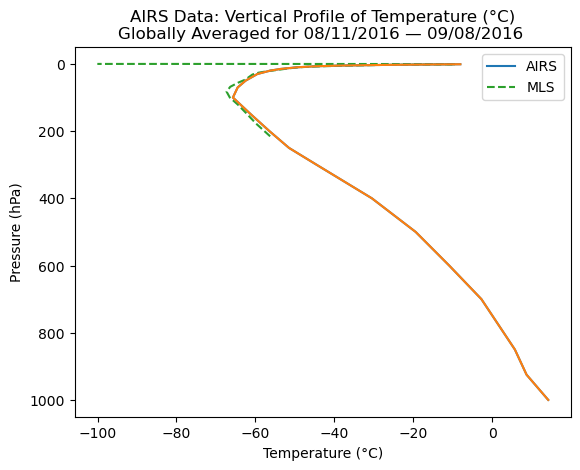

In [ ]:
CreateVertProfile(AIRS_ta, AIRS_prs, AIRS_ta, AIRS_prs, MLS_ta, MLS_ta_prs, source3="MLS", data_label="Temperature")

In [ ]:
# All atmospheric layers
# Pressure vs. Moisture (MLS/AIRS)
CreateVertProfile(AIRS_h2o, AIRS_h2o_prs, UM_hus, UM_prs)   # TODO: Add MLS data

# Pressure vs. Temperature  (AIRS)



# TODO Upper troposphere / lower stratosphere

NameError: name 'CreateVertProfile' is not defined

Asian Monsoon

North American Monsoon